# WFSS trace plotting notebook

Author: Jonathan Aguilar (jaguilar@stsci.edu)

This notebook visualizes the spectral traces for WFSS observations for a given orientation of the telescope (this is an early version, so the tools for WFSS trace visualization may evolve over time). For a more general introduction to WHIPPOT, see [WHIPPOT_tutorial](WHIPPOT_tutorial).

This notebook was originally designed for observations that use target acquisition on one star and then slew to another. WFSS does not do this, so users should use the same coordinates for their ACQ target as for their SCI target. 

The user provides the RA and Dec coordinates for the target acquisition (ACQ) star and science (SCI) star, and a telescope roll angle. These tools will then compute a) the "Special Requirment Offset" X and Y values needed to place the SCI star at the reference position, and b) the final coordinates of the SCI and ACQ stars. Coordinates are given in IDL (https://jwst-docs.stsci.edu/jwst-observatory-hardware/jwst-target-observability-and-observatory-coordinate-system/jwst-instrument-ideal-coordinate-systems#gsc.tab=0).

The user can also provide a list of extra targets in the field in the format specified below, and their IDL coordinates will also be computed. As such, this notebook is useful not just for planning target acquisition, but also for predicting to high precision the final positions of astronomical bodies in the field of view.

## Setup ##

- With installing the module:
  1. Navigate in a terminal to the directory where you have downloaded the module. This should contain the `setup.py` file.
  2. Activate your desired python environment.
  3. Run `pip install .`
  4. Copy this notebook to your working directory, and run your jupyter kernel in the appropriate environment.
- Without installing the module:
  1. Copy this notebook and `utils.py` to your working directory.
  2. In the cell below, change `from all_jwst_offset_ta import utils` to `import utils`
  3. Open the notebook as you normally would. The following python modules must be installed in the working enviroment:
     -  `ipywidgets`
     - `numpy`
     - `matplotlib`
     - `astropy`
     - `pysiaf`

In [1]:
# for development purposes
%load_ext autoreload
%autoreload 2

In [2]:
# for your system, choose an appropriate plotting backend to make pop-up window plots
# (currently, inline plots show up in the log but not directly in the notebook).
# %matplotlib throws an error if you run it first, so do inline first.
%matplotlib inline
%matplotlib osx

In [3]:
from whippot import whippot_tools
from whippot.modes import miri_wfss_tools
# if the library is not installed replace the line above with the line below 
# when `whippot_tools.py` is in the same folder as the notebook
# import whippot_tools

**WARNING**: LOCAL JWST PRD VERSION PRDOPSSOC-071 DOESN'T MATCH THE CURRENT ONLINE VERSION PRDOPSSOC-072
Please consider updating pysiaf, e.g. pip install --upgrade pysiaf or conda update pysiaf


## An example of a real field

The source coordinates below are taken from a real commissioning activity, where we needed to check that the traces wouldn't overlap.

In [4]:
# some 
sources = {
    'SCI': whippot_tools.SkyCoord("05 24 20.7552 -70 05 1.60", frame='icrs', unit=("hourangle","degree")),
    'a': whippot_tools.SkyCoord("05 24 26.33969 -70 05 22.3545", frame='icrs', unit=("hourangle","degree")),
    'b': whippot_tools.SkyCoord("05 24 28.67861 -70 05 24.4484", frame='icrs', unit=("hourangle","degree")),
    'c': whippot_tools.SkyCoord("05 24 36.22460 -70 05 28.1876", frame='icrs', unit=("hourangle","degree")),
    'd': whippot_tools.SkyCoord("05 24 25.608 -70 05 01.66", frame='icrs', unit=("hourangle","degree")),
}

In [5]:
# format the sources for easy copy-pasting
for s, c in sources.items():
    print(f"{s}: ({c.ra.deg}, {c.dec.deg})")

SCI: (81.08648, -70.08377777777777)
a: (81.10974870833334, -70.08954291666666)
b: (81.11949420833332, -70.09012455555555)
c: (81.15093583333332, -70.09116322222222)
d: (81.1067, -70.08379444444444)


In [6]:
from astropy import units
initial_values={
    'instr': 'miri',
    'sci_aper': 'mirim_illum', 
    'pa': 290.,
    'sci_ra': sources['SCI'].ra.deg, 'sci_dec': sources['SCI'].dec.deg,
    'exclude_roi': False,
}
# add a multi-line string of the other stars, copied from the cell above
initial_values['other_stars'] = """
a: (81.10974870833334, -70.08954291666666)
b: (81.11949420833332, -70.09012455555555)
c: (81.15093583333332, -70.09116322222222)
d: (81.1067, -70.08379444444444)
"""

## Use the MIRI WFSS Tools module

We have subclassed the ComputePositions() object from `whippot_tools` (see the `WHIPPOT_tutorial.ipynb` notebook) and modified it to generate WFSS-specific plots.

In [7]:
%matplotlib osx

cp1 = miri_wfss_tools.ComputePositions(initial_values=initial_values)
cp1.ui

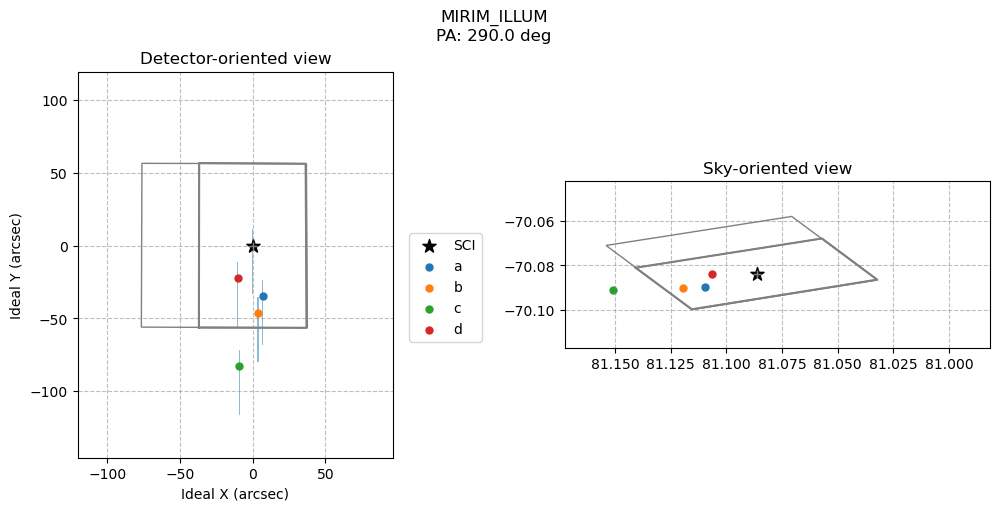

In [8]:
# Show the output plot in the notebook instead of in a popup window
%matplotlib inline
cp1.plot_scene()